# Advanced Data Handling and Machine Learning Integration for Fraud Detection

The current project showcases the integration of sophisticated data processing and machine learning techniques aimed at enhancing fraud detection systems. This involves the utilization of Python's data manipulation libraries and machine learning frameworks to prepare, analyze, and model extensive transaction datasets with high efficiency and accuracy. This setup leverages modern tools to handle large volumes of data, preprocess it for meaningful insights, and apply advanced modeling techniques such as LightGBM to predict fraudulent transactions effectively.

Detailed Explanation:
Data Preprocessing:
The process begins with the extraction of data from various sources, ensuring a comprehensive dataset that includes both transactional and identity-related information. These datasets are then merged to form a unified data frame, providing a more detailed view of each transaction. Essential preprocessing steps include handling missing values, encoding categorical variables, and deriving new features such as time components from transaction timestamps, which are crucial for capturing patterns related to fraudulent activities.

Feature Engineering:
Feature engineering plays a pivotal role in improving the predictive power of machine learning models. In this project, new features are engineered by extracting date and time information, which are believed to have significant predictive capabilities regarding fraud detection. Additionally, redundant or irrelevant features are identified and removed to optimize the model's performance and reduce computational complexity.

Machine Learning Implementation:
For the detection of fraudulent transactions, a LightGBM model—a gradient boosting framework that uses tree-based learning algorithms—is employed. It is known for its efficiency and effectiveness, especially in handling large-scale data. The model is trained and validated using a K-Fold cross-validation approach to ensure that it generalizes well on unseen data.

Model Evaluation and Optimization:
The performance of the model is meticulously evaluated using metrics such as AUC-ROC, precision, recall, and F1-score across different folds of the data. These metrics provide insights into the model's ability to distinguish between fraudulent and non-fraudulent transactions effectively. Feature importances are also analyzed to understand the driving factors behind the model's decisions, which aids in further tuning and insights into the data.

Deployment and Real-time Prediction:
Once trained and validated, the model is serialized and saved for deployment, where it can be integrated into existing systems to provide real-time fraud detection. This allows for immediate identification and prevention of potentially fraudulent transactions, thereby safeguarding user interests and enhancing security.


This project illustrates the effective use of advanced data handling and machine learning techniques to tackle the pressing issue of fraud in transactional systems. By leveraging Python's powerful libraries and the LightGBM framework, it is possible to develop a robust system capable of detecting and preventing fraud in a dynamic and scalable manner. This not only enhances operational efficiency but also boosts security protocols essential for maintaining trust and reliability in financial transactions.

In [1]:
import pandas as pd

In [2]:
import numpy as np

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

import datetime 
import lightgbm as lgb # also im trying

import os
import gc as GarbageCollector

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_1 = '/content/drive/MyDrive/Dataset/train_transaction.csv'
df_1 = pd.read_csv(path_1)

In [5]:
path_2 = '/content/drive/MyDrive/Dataset/train_identity.csv'
df_2 = pd.read_csv(path_2)

In [6]:
path_3 = '/content/drive/MyDrive/Dataset/test_transaction.csv'
df_3 = pd.read_csv(path_3)

In [7]:
path_4 = '/content/drive/MyDrive/Dataset/test_identity.csv'
df_4 = pd.read_csv(path_4)

In [40]:
df = df_1.merge(df_2, how='left', left_index=True, right_index=True)

In [41]:
def fix_dates(df):
    
    # create date column
    START_DATE = '2017-12-01' # found this start date from commets 
    
    # required START_DATE since DT is a time delta from start
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    df['hour']  = df['TransactionDT'].dt.hour
    df['day']   = df['TransactionDT'].dt.day
    df['dow']   = df['TransactionDT'].dt.dayofweek
    df['month'] = df['TransactionDT'].dt.month
    df['year']  = df['TransactionDT'].dt.year
    
    df.drop(columns=['TransactionDT'], inplace=True)
    
    return df

df = fix_dates(df)

In [42]:
df

,TransactionID_x,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_36,id_37,id_38,DeviceType,DeviceInfo,hour,day,dow,month,year
0,2987000,0,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,2,5,12,2017
1,2987001,0,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,F,F,T,mobile,iOS Device,0,2,5,12,2017
2,2987002,0,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,F,T,T,desktop,Windows,0,2,5,12,2017
3,2987003,0,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,F,T,T,desktop,NaN,0,2,5,12,2017
4,2987004,0,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,F,T,T,desktop,MacOS,0,2,5,12,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,23,1,4,6,2018
590536,3577536,0,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,23,1,4,6,2018
590537,3577537,0,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,23,1,4,6,2018
590538,3577538,0,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,23,1,4,6,2018


In [43]:
df_test  = df_3.merge(df_4, how='left',   left_index=True, right_index=True)
df_test = fix_dates(df_test)
df_test

,TransactionID_x,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id-36,id-37,id-38,DeviceType,DeviceInfo,hour,day,dow,month,year
0,3663549,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13,0,2,0,7,2018
1,3663550,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,F,T,T,mobile,LGLS676 Build/MXB48T,0,2,0,7,2018
2,3663551,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,T,T,F,desktop,Trident/7.0,0,2,0,7,2018
3,3663552,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13,0,2,0,7,2018
4,3663553,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,F,T,F,mobile,SM-G9650 Build/R16NW,0,2,0,7,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,...,NaN,NaN,NaN,NaN,NaN,23,31,0,12,2018
506687,4170236,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,...,NaN,NaN,NaN,NaN,NaN,23,31,0,12,2018
506688,4170237,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,...,NaN,NaN,NaN,NaN,NaN,23,31,0,12,2018
506689,4170238,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,...,NaN,NaN,NaN,NaN,NaN,23,31,0,12,2018


In [44]:
# ground truth
truth = df['isFraud']
df.drop(columns=['isFraud'], inplace=True)

In [46]:
df_columns = df.columns
te_columns = df_test.columns
MISSING_TOL = 0.5

# remove columns that dont matter
one_value_cols      = [col for col in df_columns if df[col].nunique() <= 1]
one_value_cols_test = [col for col in te_columns if df_test[col].nunique() <= 1]

# remove columns with too many null values
many_null_cols      = [col for col in df_columns if df[col].isnull().sum() / df.shape[0] > MISSING_TOL]
many_null_cols_test = [col for col in te_columns if df_test[col].isnull().sum()  / df_test.shape[0]  > MISSING_TOL]

# drop
cols_to_rm = list(set(one_value_cols + one_value_cols_test + many_null_cols + many_null_cols_test))

df.drop(cols_to_rm, axis=1, inplace=True, errors='ignore')
df_test.drop(cols_to_rm, axis=1, inplace=True,  errors='ignore')

In [48]:
df.shape, df_test.shape

((590540, 221), (506691, 221))

In [50]:
#transform each cat feature
cat_f = df.select_dtypes(include='category').columns.tolist()
obj_f = df.select_dtypes(include='object').columns.tolist()

features = list(set(cat_f + obj_f))
print("Transforming features: ", features)

# note we are allowed to consider test values for this transform since this can be done in real life
for f in features:
    lbl = LabelEncoder()
    lbl.fit(list(df[f].values) + list(df_test[f].values))
    df[f] = lbl.transform(list(df[f].values))
    df_test[f] = lbl.transform(list(df_test[f].values)) 

Transforming features:  ['ProductCD', 'M6', 'card4', 'M3', 'M4', 'P_emaildomain', 'card6', 'M2', 'M1']


In [52]:
# stole these from a guy that already found these
params = {'feature_fraction': 0.4, # use 40% of features to capture feature feature interactions
          'bagging_fraction': 0.4, # use 40% of the data for creating trees (default = 100% which would be slow)
          'min_data_in_leaf': 100, # min_data_in_leaf is the smallest number of nodes that can be used to create a leaf node, higher values prevent over fitting
          'objective': 'binary', 
          'max_depth': -1,
          "boosting_type": "gbdt", # default!
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'random_state': 47
         }

splits = 5
folds = KFold(n_splits = splits)
oof = np.zeros(len(df))

In [53]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

f1 = []
recall = []
precision = []
acc = []

def save_scores_per_fold(__truth, __pred):
    # >= 0.5 => 1 else class = 0
    truth, pred = __truth.values, __pred >= .5
    
    f1.append(f1_score(truth, pred))
    recall.append(recall_score(truth, pred))
    precision.append(precision_score(truth, pred))
    acc.append(accuracy_score(truth, pred))

# save learned feature importances
feature_importances            = pd.DataFrame()
feature_importances['feature'] = df.columns
    
# use Kfold to generate splitting index in the training set
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df.values, truth.values)):
    print("Fold Number: {}".format(fold_))
    
    # train set
    train_df, y_train_df = df.iloc[trn_idx], truth.iloc[trn_idx]
    
    # validation set
    valid_df, y_valid_df = df.iloc[val_idx], truth.iloc[val_idx]
    
    # attempt to use a GPU via Dataset
    trn_data = lgb.Dataset(train_df, label=y_train_df)
    val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
    # use lgbm
    clf = lgb.train(params,
                    trn_data,
                    10000, # 10000 trees
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500, # print info per 500 rounds
                    early_stopping_rounds=500)
    feature_importances[f'fold_{fold_+1}'] = clf.feature_importance() 

    pred = clf.predict(valid_df)
    oof[val_idx] = pred
    save_scores_per_fold(y_valid_df, pred)
    print( "Fold's auc = ", roc_auc_score(y_valid_df, pred) )

Fold Number: 0


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.976879	valid_1's auc: 0.908341
[1000]	training's auc: 0.989332	valid_1's auc: 0.9089
Early stopping, best iteration is:
[906]	training's auc: 0.987883	valid_1's auc: 0.910168
Fold's auc =  0.9101683120917815
Fold Number: 1


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.975771	valid_1's auc: 0.925933
[1000]	training's auc: 0.989583	valid_1's auc: 0.927171
Early stopping, best iteration is:
[914]	training's auc: 0.988136	valid_1's auc: 0.927577
Fold's auc =  0.9275774765878999
Fold Number: 2


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.976307	valid_1's auc: 0.917412
[1000]	training's auc: 0.98878	valid_1's auc: 0.917978
Early stopping, best iteration is:
[792]	training's auc: 0.985011	valid_1's auc: 0.919296
Fold's auc =  0.9192957012514497
Fold Number: 3


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.97513	valid_1's auc: 0.934954
[1000]	training's auc: 0.98842	valid_1's auc: 0.936344
Early stopping, best iteration is:
[958]	training's auc: 0.987846	valid_1's auc: 0.936722
Fold's auc =  0.9367222380091246
Fold Number: 4


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.975895	valid_1's auc: 0.914797
[1000]	training's auc: 0.9887	valid_1's auc: 0.913278
Early stopping, best iteration is:
[700]	training's auc: 0.982734	valid_1's auc: 0.916102
Fold's auc =  0.9161015784296681


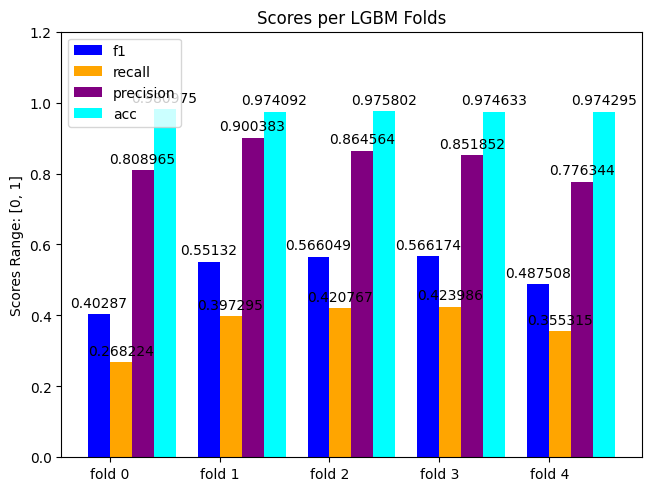

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the variables are defined here:
# metrics, splits, f1, recall, precision, acc

x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

colors = ['blue', 'orange', 'purple', 'cyan']   # specify colors for each attribute
color_index = 0

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[color_index])
    ax.bar_label(rects, padding=3)
    multiplier += 1
    color_index += 1

ax.set_ylabel('Scores Range: [0, 1]')
ax.set_title('Scores per LGBM Folds')
ax.set_xticks(x + width/2)
ax.set_xticklabels(metrics)
ax.legend(loc='upper left')
ax.set_ylim(0, 1.2)

plt.show()


In [55]:
df

,TransactionID_x,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V316,V317,V318,V319,V320,V321,hour,day,dow,month
0,2987000,68.50,4,13926,NaN,150.0,1,142.0,1,315.0,...,0.0,117.0,0.0,0.000000,0.000000,0.000000,0,2,5,12
1,2987001,29.00,4,2755,404.0,150.0,2,102.0,1,325.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,2,5,12
2,2987002,59.00,4,4663,490.0,150.0,4,166.0,2,330.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,2,5,12
3,2987003,50.00,4,18132,567.0,150.0,2,117.0,2,476.0,...,50.0,1404.0,790.0,0.000000,0.000000,0.000000,0,2,5,12
4,2987004,50.00,1,4497,514.0,150.0,2,102.0,1,420.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,2,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,49.00,4,6550,NaN,150.0,4,226.0,2,272.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,23,1,4,6
590536,3577536,39.50,4,10444,225.0,150.0,2,224.0,2,204.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,23,1,4,6
590537,3577537,30.95,4,12037,595.0,150.0,2,224.0,2,231.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,23,1,4,6
590538,3577538,117.00,4,7826,481.0,150.0,2,224.0,2,387.0,...,0.0,2234.0,0.0,0.000000,0.000000,0.000000,23,1,4,6


In [57]:
df_test

,TransactionID_x,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V316,V317,V318,V319,V320,V321,hour,day,dow,month
0,3663549,31.950,4,10409,111.0,150.0,4,226.0,2,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,7
1,3663550,49.000,4,4272,111.0,150.0,4,226.0,2,299.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,7
2,3663551,171.000,4,4476,574.0,150.0,4,226.0,2,472.0,...,0.0,0.0,0.0,0.0,263.0,0.0,0,2,0,7
3,3663552,284.950,4,10989,360.0,150.0,4,166.0,2,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,7
4,3663553,67.950,4,18018,452.0,150.0,2,117.0,2,264.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,94.679,0,13832,375.0,185.0,2,224.0,2,284.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23,31,0,12
506687,4170236,12.173,0,3154,408.0,185.0,2,224.0,2,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,23,31,0,12
506688,4170237,49.000,4,16661,490.0,150.0,4,226.0,2,327.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23,31,0,12
506689,4170238,202.000,4,16621,516.0,150.0,2,224.0,2,177.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23,31,0,12


In [58]:
import pandas as pd

# Assuming you have a DataFrame called df_test with 500,000 rows

# Select the first 10,000 rows
subset_df = df_test.head(10000)

# Save the subset to a CSV file
subset_df.to_csv('simulate.csv', index=False)


In [59]:
import pickle

In [60]:
with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [61]:
from google.colab import files
files.download('clf.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
pred1 = clf.predict(df_test)

In [63]:
pred1

array([0.00737636, 0.00209312, 0.00188366, ..., 0.01670619, 0.01989563,
       0.00364166])